# Subreddit Predictor

# 1: Identify the Goal

The purpose of this project is to create a Machine Learning model which can read a reddit post title and predict which subreddit it belongs to. For simplicity we will train the model only to distinguish between a small number of subreddits. These subreddits are chosen to have a wide variaty of post titles. Some subreddits will be trivial, such as r/AmITheAsshole in which every post contains the word "AITA" or "WIBTA", abriviations for "Am I the asshole" and "Would I be the asshole" respectively. Other subreddits such as r/Awww and r/pics have post titles which contain very little information.

In [22]:
top_subreddits = ['announcements', 'funny', 'AskReddit', 'dataisbeautiful', 'Awww', 'datascience', 'pics', 'science', 'worldnews', 'videos', 'AmItheAsshole']

# 2: Aquire the Data

Reddit data is usually gathered through an API and by using the wrapper "praw". For larger amounts of data, or for historical data we can use PushShift and it's wrapper "psaw". Unfortunately, PushShift is down right now so we will have to stick with "praw". This limits the amount of data we can gather. We will limit ourselves to the last 1000 posts on each subreddit.

In [23]:
import praw
import secrets

user_agent = "Subreddit-Predictor 0.2 by /u/IsThisATrollBot"

reddit = praw.Reddit(
    client_id=secrets.client_ID,
    client_secret=secrets.client_secret,
    password=secrets.password,
    user_agent=user_agent,
    username=secrets.username,
)

In [24]:
# Create an empty list to store the posts
posts = []

# Iterate through the subreddits and get the last 1000 posts from each
for sub in top_subreddits:
    subreddit_posts = reddit.subreddit(sub).new(limit=1000)
    for post in subreddit_posts:
        posts.append(post)

In [25]:
import pandas as pd

# Create a list of dictionaries containing the data for each post
data = [{'id': post.id, 'title': post.title, 'subreddit': post.subreddit.display_name} for post in posts]

# Create a Pandas dataframe from the list of dictionaries
df_raw = pd.DataFrame(data)
df_raw = df_raw.set_index('id')

# 3: Analyze the Data

In [442]:
df_raw

,title,subreddit
id,,
t93ec3,This subreddit is closed for new posts and com...,announcements
pg006s,COVID denialism and policy clarifications,announcements
pbmy5y,"Debate, dissent, and protest on Reddit",announcements
nw2hs6,Sunsetting Secret Santa and Reddit Gifts,announcements
mi01fg,Second,announcements
...,...,...
10ds6b2,WIBTA if I lied to my husband about not keepin...,AmItheAsshole
10ds0k3,AITA for refusing to work?,AmItheAsshole
10drxdx,"AITA for ""not wanting"" to sit next to my best ...",AmItheAsshole


## Remove Empty and Repeated entires

In [335]:
df = df_raw

# Make all the text lowercase
df['title'] = df['title'].str.lower()

In [336]:
# Remove empty rows
df['title'] = df['title'].str.strip()
filter = df['title'] == ''
print(len(df[filter]))
df = df.drop(df[filter].index)

0


In [337]:
# Find any duplicates
df[df.duplicated(keep = False)]

,title,subreddit
id,,
c0gmy,"we are aware that reddit appears hung over, an...",announcements
c0gl6,"we are aware that reddit appears hung over, an...",announcements
10fdr2b,irony,funny
10dobvt,irony,funny
10gf9jv,what’s the most interesting hypothetical quest...,AskReddit
...,...,...
10f4qdj,watch please,videos
10exojv,this cat will make you burst out laughing - fu...,videos
10evy5a,5 money mistakes to avoid in your 20s!,videos


In [338]:
# Drop the duplicates
filter = df.duplicated()
df = df[~filter]
df

,title,subreddit
id,,
t93ec3,this subreddit is closed for new posts and com...,announcements
pg006s,covid denialism and policy clarifications,announcements
pbmy5y,"debate, dissent, and protest on reddit",announcements
nw2hs6,sunsetting secret santa and reddit gifts,announcements
mi01fg,second,announcements
...,...,...
10dokmp,aita for throwing away gifts given by mil afte...,AmItheAsshole
10dohz5,aita for taking back the paintball gun my wife...,AmItheAsshole
10dofsb,wibta for eating my roommate's food?,AmItheAsshole


## Length of Post

How much does the length of a post title tell us about the subreddit?

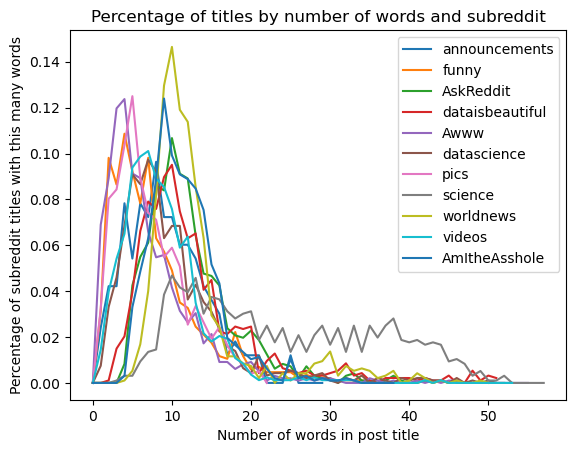

In [339]:
import matplotlib.pyplot as plt

# Initialize an empty dictionary to store the data
data = {}

# Iterate over the top_subreddits
for subreddit in top_subreddits:
    # Get the titles for the subreddit
    titles = df_raw[df_raw['subreddit'] == subreddit]['title']
    # Get the number of words in the titles
    num_words = [len(title.split()) for title in titles]
    # Get the percentage of titles for the subreddit with a specific number of words
    percentages = []
    for i in range(max(num_words)):
        percentages.append(num_words.count(i)/len(num_words))
    # Add the data to the dictionary
    data[subreddit] = percentages

# Plot the data
for subreddit, percentages in data.items():
    plt.plot(range(len(percentages)), percentages, label=subreddit)

# Add labels and title
plt.xlabel("Number of words in post title")
plt.ylabel("Percentage of subreddit titles with this many words")
plt.title("Percentage of titles by number of words and subreddit")
plt.legend()

# Show
plt.show()

The length of a post doesn't seem to tell us too much. Longer posts are usually in r/science. The posts in r/worldnews peak around 11 words, probably because they are all news headlines.

Looking at the same graph for character length is a little bit more revealing, but not much.

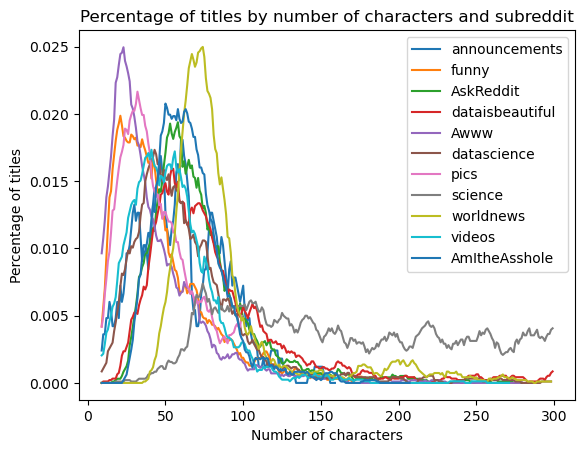

In [340]:
# Define the window size for the moving average
window_size = 10

# Initialize an empty dictionary to store the data
data = {}

# Iterate over the top_subreddits
for subreddit in top_subreddits:
    # Get the titles for the subreddit
    titles = df_raw[df_raw['subreddit'] == subreddit]['title']
    # Get the number of characters in the titles
    num_chars = [len(title) for title in titles]
    # Get the percentage of titles for the subreddit with a specific number of characters
    percentages = []
    for i in range(max(num_chars)):
        percentages.append(num_chars.count(i)/len(num_chars))
    # Apply moving average
    percentages_smooth = pd.Series(percentages).rolling(window_size).mean()
    # Add the data to the dictionary
    data[subreddit] = percentages_smooth

# Plot the data
for subreddit, percentages in data.items():
    plt.plot(range(len(percentages)), percentages, label=subreddit)

# Add labels and title
plt.xlabel("Number of characters")
plt.ylabel("Percentage of titles")
plt.title("Percentage of titles by number of characters and subreddit")
plt.legend()

# Show
plt.show()


## Contains Specific Expressions

Let's look at specific expressions such as "aita", "data", "[oc]", and "?" to see what they tell us about the specific subreddit.
We can also check to see if there are emojis.

In [341]:
conditions = {}

def contains(key):
    def foo(sentence):
        return (key in sentence)
    return foo

def add_contains_key(key):
    conditions['contains "'+key+'"'] = contains(key)

key_words = ['aita', '#', '[oc]', '(oc)', '?', '!', 'r/', 'data']
for key in key_words:
    add_contains_key(key)



def has_emoji(sentence):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64f"  # emoticons
                               u"\U0001F300-\U0001F5ff"  # symbols & pictographs
                               u"\U0001F680-\U0001F6ff"  # transport & map symbols
                               u"\U0001F1e0-\U0001F1ff"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.search(sentence) is not None

conditions['emoji'] = has_emoji


In [342]:
table = pd.DataFrame(columns=['Condition', '% Correct', 'Total Affected'])

for key, val in conditions.items():
    filter = df['title'].apply(val)
    temp_df = df[filter]
    total = len(temp_df)
    if total == 0: break

    cor = []
    for subreddit in top_subreddits:
        cor.append(len(temp_df[temp_df['subreddit'] == subreddit]) / total)

    correct_percent = max(cor)

    table = pd.concat(
        [table, pd.DataFrame({'Condition': [key], '% Correct': [correct_percent], 'Total Affected': [total]})],
        ignore_index=True)

table

,Condition,% Correct,Total Affected
0,"contains ""aita""",1.000000,844
1,"contains ""#""",0.603175,63
2,"contains ""[oc]""",0.907749,813
3,"contains ""(oc)""",0.533333,60
4,"contains ""?""",0.404452,2381
5,"contains ""!""",0.363636,407
6,"contains ""r/""",0.264706,34
7,"contains ""data""",0.822547,479
8,emoji,0.546667,225


Let's now find a list of all the words used more than 100 times. And we'll do the same key_words thing

In [343]:
from collections import Counter

# Create a list of all words in the title column
all_words = ' '.join(df['title']).split()
# Create a Counter object to count the occurrences of each word
word_count = Counter(all_words)
# Create a list of words that appear more than 100 times
frequent_words = [word for word, count in word_count.items() if count > 100]
# Print the list of frequent words
print(frequent_words)



['this', 'is', 'for', 'new', 'and', 'to', 'the', 'on', 'an', 'a', 'you', 'can', 'with', 'our', 'from', 'who', 'into', 'how', 'your', 'some', 'have', 'of', 'i', 'us', 'are', 'we', 'had', 'what', 'as', 'in', 'about', 'more', 'people', 'will', 'like', 'has', 'not', 'my', 'could', 'be', 'it', 'so', 'was', 'but', 'time', 'all', 'that', 'year', 'just', 'out', 'their', 'up', 'by', 'at', '-', 'when', 'data', 'than', 'if', 'over', 'do', 'work', '[oc]', 'world', 'most', 'his', 'me', 'best', 'get', 'she', 'friend', 'made', 'would', 'her', 'first', 'which', 'one', 'or', 'they', 'found', '&', 'were', 'study', 'did', 'years', 'he', 'after', '|', 'telling', 'ukraine', '2022', 'science', 'aita', 'wibta']


In [344]:
conditions = {}

def contains(key):
    def foo(sentence):
        return (key in sentence.split())

    return foo


def add_contains_key(key):
    conditions['contains "' + key + '"'] = contains(key)


for key in frequent_words:
    add_contains_key(key)

table = pd.DataFrame(columns=['Condition', '% Correct', 'Total Affected'])

for key, val in conditions.items():
    filter = df['title'].apply(val)
    temp_df = df[filter]
    total = len(temp_df)
    if total == 0: break

    cor = []
    for subreddit in top_subreddits:
        cor.append(len(temp_df[temp_df['subreddit'] == subreddit]) / total)

    correct_percent = max(cor)

    table = pd.concat(
        [table, pd.DataFrame({'Condition': [key], '% Correct': [correct_percent], 'Total Affected': [total]})],
        ignore_index=True)

table

,Condition,% Correct,Total Affected
0,"contains ""this""",0.274157,445
1,"contains ""is""",0.294582,886
2,"contains ""for""",0.469912,1828
3,"contains ""new""",0.371345,342
4,"contains ""and""",0.310201,1441
...,...,...,...
89,"contains ""ukraine""",0.928571,140
90,"contains ""2022""",0.785235,149
91,"contains ""science""",0.912500,160
92,"contains ""aita""",1.000000,816


Remember that there are 11 subreddits to choose from, so any guess better than 10% is still good.
This tells me that a simple Bag-of-Words algorithm will probably not do too bad.


# 4: Naive Solution

The easiest Naive Solution would be to use Bag-of-Words to vectorize each post title, then you a dicision tree based algorithm to classify it.

In [345]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Split the dataframe into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['subreddit'], test_size=0.2)

# Vectorize the post titles using Bag-of-Words
vectorizer = CountVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

# Train a random forest model to classify each title to its corresponding subreddit
clf = RandomForestClassifier()
clf.fit(X_train_vectors, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test_vectors)

In [346]:
# Get classification report
classification_rep = classification_report(y_test, y_pred, output_dict=True)
#classification_rep

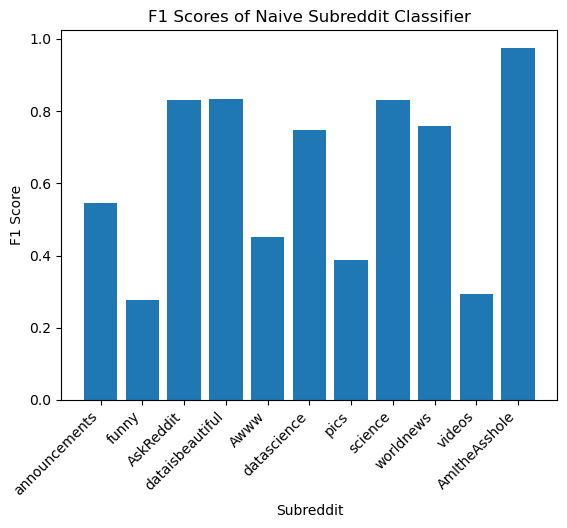

In [347]:
# Plot bar graph
bar_data = {subreddit: classification_rep[subreddit]['f1-score'] for subreddit in top_subreddits}
plt.bar(bar_data.keys(), bar_data.values())
plt.xlabel('Subreddit')
plt.ylabel('F1 Score')
# Set the x-axis tick labels
plt.xticks( rotation=45, ha='right')
plt.title('F1 Scores of Naive Subreddit Classifier')
plt.show()

# 5: How to Improve Results

There are many imidiately obvious things I can do to improve results:
- Hyperparameter tuning
- More sophisticated embedding algorithms like Doc-2-Vec
- Include more additional information like "has an emoji" or "title length"
- Compare other classification algorithms like XGBoost or Support Vector Machines
- Include more advanced information like "number of miss-spellings" and "sentiment"
- More Data

# 6: Create the New Models

## Classes

In order to improve the results I need to test a lot of models. In a seperate notebook I've created three classes to help with that. This will organize the information better.

In [348]:
%run Classes.ipynb

In [349]:
# Get the data again
data = [{'id': post.id, 'title': post.title, 'subreddit': post.subreddit.display_name} for post in posts]
df_raw = pd.DataFrame(data)

# Instantiate the Object
obj = Subreddit_Predictor()
obj.add_data(df_raw)
obj.ready_data()

In [350]:
obj.full_data

,title,subreddit,subreddit_num
id,,,
t93ec3,this subreddit is closed for new posts and com...,announcements,3
pg006s,covid denialism and policy clarifications,announcements,3
pbmy5y,debate dissent and protest on reddit,announcements,3
nw2hs6,sunsetting secret santa and reddit gifts,announcements,3
mi01fg,second,announcements,3
...,...,...,...
10dokmp,aita for throwing away gifts given by mil afte...,AmItheAsshole,0
10dohz5,aita for taking back the paintball gun my wife...,AmItheAsshole,0
10dofsb,wibta for eating my roommates food,AmItheAsshole,0


## Vectorizers

Here we will create a few different vectorizers

### Bag-of-Words

In [351]:
def _BoW_train(X_train):

    model = CountVectorizer()
    model.fit_transform(X_train)
    return model

def _BoW_embed(titles, model):
    embedding = model.transform(titles).toarray()
    df = pd.DataFrame(embedding, index=titles.index)

    # This is just to make sure the columns names are all of the right type
    num_of_cols = len(df.columns)
    new_cols = ['BoW' + ": " + str(i).zfill(len(str(num_of_cols))) for i in range(num_of_cols)]
    df.columns = new_cols

    return df

BoW = Vectorizer('BoW')
BoW.description = "Naive Bag-of-Words embedding"

BoW._train = _BoW_train
BoW._embed = _BoW_embed

obj.add_vectorizer(BoW)
obj.add_feature_vectors('BoW')

obj.Feature_Vectors['BoW']

,BoW: 00000,BoW: 00001,BoW: 00002,BoW: 00003,BoW: 00004,BoW: 00005,BoW: 00006,BoW: 00007,BoW: 00008,BoW: 00009,...,BoW: 14531,BoW: 14532,BoW: 14533,BoW: 14534,BoW: 14535,BoW: 14536,BoW: 14537,BoW: 14538,BoW: 14539,BoW: 14540
id,,,,,,,,,,,,,,,,,,,,,
t93ec3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pg006s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pbmy5y,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
nw2hs6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mi01fg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10dokmp,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10dohz5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10dofsb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Bag-of-Words+

Here I want to add a few simple things to the BoW vectorizer.
But because the text is cleaned before hand, I can't add anything like emojis or question marks.
So best I can do is add character length.

In [352]:
def _BoW_embed_plus(titles, model):

    #Old Stuff
    embedding = model.transform(titles).toarray()
    df = pd.DataFrame(embedding, index=titles.index)
    num_of_cols = len(df.columns)
    new_cols = ['BoW' + ": " + str(i).zfill(len(str(num_of_cols))) for i in range(num_of_cols)]
    df.columns = new_cols

    #Adding Length
    lengths = titles.apply(len)
    df['length'] = lengths
    return df

BoW_plus = Vectorizer('BoW+')
BoW_plus.description = "Naive Bag-of-Words embedding plus length of title in characters"

BoW_plus._train = _BoW_train
BoW_plus._embed = _BoW_embed_plus

obj.add_vectorizer(BoW_plus)
obj.add_feature_vectors('BoW+')

obj.Feature_Vectors['BoW+']

,BoW: 00000,BoW: 00001,BoW: 00002,BoW: 00003,BoW: 00004,BoW: 00005,BoW: 00006,BoW: 00007,BoW: 00008,BoW: 00009,...,BoW: 14532,BoW: 14533,BoW: 14534,BoW: 14535,BoW: 14536,BoW: 14537,BoW: 14538,BoW: 14539,BoW: 14540,length
id,,,,,,,,,,,,,,,,,,,,,
t93ec3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,153
pg006s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,41
pbmy5y,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,36
nw2hs6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,40
mi01fg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10dokmp,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,86
10dohz5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,66
10dofsb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,34


### Doc-2-Vec

The next vectorization algorithms will use Doc-2-Vec

In [353]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def _D2V_train(X_train):
    # Create a list of TaggedDocument objects for training
    tagged_data = [TaggedDocument(words=title.split(), tags=[str(index)]) for index, title in X_train.iteritems()]

    # Initialize a Doc2Vec model with the standard english corpus
    model = Doc2Vec(vector_size=100, min_count=2, epochs=40)
    model.build_vocab(tagged_data)

    # Train the model on the input data
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

    return model


def _D2V_embed(titles, model):

    # Get the vectorized titles from the doc2vec model
    vectors = [model.infer_vector(title.split()) for title in titles]

    # Create the embedding dataframe
    df = pd.DataFrame(titles)
    df = pd.DataFrame(vectors)
    df['id'] = titles.index
    df = df.set_index('id')

    # This is just to make sure the columns names are all of the right type
    num_of_cols = len(df.columns)
    new_cols = ['D2V' + ": " + str(i).zfill(len(str(num_of_cols))) for i in range(num_of_cols)]
    df.columns = new_cols

    return df

In [354]:
D2V = Vectorizer('D2V')
D2V.description = 'Doc-2-Vec embedding using Doc2Vec(vector_size=100, min_count=2, epochs=40)'
D2V._train = _D2V_train
D2V._embed = _D2V_embed

obj.add_vectorizer(D2V)
obj.add_feature_vectors('D2V')

obj.Feature_Vectors['D2V']

,D2V: 000,D2V: 001,D2V: 002,D2V: 003,D2V: 004,D2V: 005,D2V: 006,D2V: 007,D2V: 008,D2V: 009,...,D2V: 090,D2V: 091,D2V: 092,D2V: 093,D2V: 094,D2V: 095,D2V: 096,D2V: 097,D2V: 098,D2V: 099
id,,,,,,,,,,,,,,,,,,,,,
t93ec3,0.199677,-0.066420,0.471728,0.106765,-0.364484,-0.070302,0.078706,0.311334,-0.203353,-0.236512,...,0.163793,0.110429,-0.348760,-0.373001,0.396745,0.260595,0.099316,-0.154028,-0.251267,-0.327737
pg006s,-0.050648,0.093568,0.039793,0.000433,0.108705,-0.119107,-0.045353,0.207495,-0.067733,-0.049384,...,0.257188,-0.052267,-0.045000,0.057403,0.208889,0.034971,0.040380,-0.059608,0.020333,0.051279
pbmy5y,-0.214753,-0.025722,0.186193,-0.182343,0.026143,-0.014051,-0.042635,0.167171,-0.105270,-0.070507,...,0.324203,0.069680,0.008121,-0.167256,0.174626,0.223875,0.070137,-0.069191,0.084159,-0.071885
nw2hs6,-0.127788,0.095632,0.105127,-0.008989,0.060775,0.065381,-0.127301,0.271264,-0.127050,0.057670,...,0.297513,0.132003,0.005084,-0.178693,0.158622,0.166943,0.066944,-0.050883,0.080061,-0.093428
mi01fg,0.019238,0.009022,0.048204,0.064945,0.063683,-0.143253,0.055815,0.215366,-0.105700,-0.049153,...,0.121458,0.042785,0.109285,0.022867,0.206901,0.078705,0.007510,-0.075522,0.028528,0.094860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10dokmp,-0.102132,0.010182,0.133048,0.105552,-0.022564,-0.119654,0.167945,0.147751,0.239618,-0.604612,...,-0.152017,0.025632,-0.027746,0.674656,0.282549,-0.200642,-0.429228,-0.059682,-0.122708,-0.110084
10dohz5,-0.021050,0.028422,0.024958,-0.103548,0.048643,0.020620,0.046492,0.174322,-0.156268,-0.212621,...,0.244590,0.133629,0.084886,0.006738,0.091503,0.014445,0.058722,-0.143416,-0.090167,-0.035773
10dofsb,-0.055786,0.110457,-0.120932,-0.102519,-0.027962,0.175138,-0.082060,0.085957,0.018336,-0.034152,...,-0.005241,0.130169,-0.074855,0.011097,0.121844,-0.105363,-0.030520,-0.023822,-0.138436,-0.099975


### Doc-2-Vec plus

Same as the previous plus, just add a little extra info about length

In [355]:
def _D2V_embed_plus(titles, model):

    #Normal Stuff
    vectors = [model.infer_vector(title.split()) for title in titles]
    df = pd.DataFrame(titles)
    df = pd.DataFrame(vectors)
    df['id'] = titles.index
    df = df.set_index('id')
    num_of_cols = len(df.columns)
    new_cols = ['D2V' + ": " + str(i).zfill(len(str(num_of_cols))) for i in range(num_of_cols)]
    df.columns = new_cols

    # Add additional information
    lengths = titles.apply(len)
    df['length'] = lengths

    return df

D2V_plus = Vectorizer('D2V+')
D2V_plus.description = 'Doc-2-Vec embedding using Doc2Vec(vector_size=100, min_count=2, epochs=40), plus an extra column about length'
D2V_plus._train = _D2V_train
D2V_plus._embed = _D2V_embed_plus

obj.add_vectorizer(D2V_plus)
obj.add_feature_vectors('D2V+')

obj.Feature_Vectors['D2V+']

,D2V: 000,D2V: 001,D2V: 002,D2V: 003,D2V: 004,D2V: 005,D2V: 006,D2V: 007,D2V: 008,D2V: 009,...,D2V: 091,D2V: 092,D2V: 093,D2V: 094,D2V: 095,D2V: 096,D2V: 097,D2V: 098,D2V: 099,length
id,,,,,,,,,,,,,,,,,,,,,
t93ec3,0.194861,-0.157487,0.368709,0.292271,-0.191198,0.002507,0.054284,0.435143,0.035593,-0.189640,...,0.006994,0.084043,-0.014597,0.155841,0.262661,0.180462,0.129595,-0.223654,-0.169250,153
pg006s,-0.108029,0.130645,0.030716,0.093088,0.102498,-0.106616,-0.036866,0.196524,-0.077178,-0.042743,...,-0.028933,-0.043731,0.060107,0.181932,0.018400,0.116558,-0.011463,0.037260,0.059505,41
pbmy5y,-0.316328,-0.035976,0.220902,-0.094356,0.018812,0.036577,-0.059913,0.188794,-0.057049,-0.036572,...,0.120287,0.009867,-0.072813,0.123999,0.247646,0.174319,0.025513,0.075285,-0.060639,36
nw2hs6,-0.197849,0.082713,0.119679,0.079713,0.031332,0.072085,-0.024715,0.234827,-0.076141,0.069202,...,0.112297,0.120630,-0.092453,0.127609,0.184060,0.102739,0.062685,0.001284,-0.082681,40
mi01fg,-0.011875,0.046613,0.027076,0.041915,0.047357,-0.143743,0.091158,0.213280,-0.108280,-0.107204,...,0.042468,0.063558,0.040225,0.243827,0.091045,0.012283,-0.090817,0.045990,0.071886,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10dokmp,-0.025775,-0.035210,0.049376,0.213377,-0.157274,-0.009494,-0.003837,0.094457,0.491979,-0.310640,...,-0.043135,-0.171053,0.676594,0.320719,-0.168577,-0.331822,-0.192342,-0.237328,-0.351940,86
10dohz5,0.012754,-0.044096,0.075272,0.043969,0.103703,-0.105034,0.092428,0.240632,-0.215057,-0.218345,...,0.083887,0.130639,0.105042,0.236367,0.134975,0.027419,-0.247158,-0.037637,-0.047696,66
10dofsb,-0.114035,0.071439,-0.147453,-0.143936,-0.015955,0.111438,0.034395,0.054266,-0.051043,0.105852,...,0.184451,-0.052004,-0.001920,0.127065,-0.035292,0.116983,0.038554,-0.081491,-0.058129,34


## Classifiers


### Support Vector Machine

In [356]:
from sklearn.svm import SVC

def _SVM_train(X_train, Y_train):
    # Initialize the SVM model
    svm = SVC()
    # Train the model on the input data
    svm.fit(X_train, Y_train)
    # Output the trained model
    return svm

def _SVM_predict(title_vectors, model):
    # Make predictions on the input data
    predictions = model.predict(title_vectors)
    # Output the predictions as a pandas series
    return pd.Series(predictions)



In [357]:
SVM = Classifier('SVM')
SVM._train = _SVM_train
SVM._predict = _SVM_predict

obj.add_classifier(SVM)

### Random Forrest

In [358]:
from sklearn.ensemble import RandomForestClassifier

def _RandomForest_train(X_train, Y_train):
    # Initialize the Random Forest model
    rf = RandomForestClassifier()
    # Train the model on the input data
    rf.fit(X_train, Y_train)
    # Output the trained model
    return rf

def _RandomForest_predict(title_vectors, model):
    # Make predictions on the input data
    predictions = model.predict(title_vectors)
    # Output the predictions as a pandas series
    return pd.Series(predictions)

In [359]:
RF = Classifier('RF')
RF._train = _RandomForest_train
RF._predict = _RandomForest_predict

obj.add_classifier(RF)

### XGBoost

In [360]:
from xgboost import XGBClassifier

def _XGBoost_train(X_train, Y_train):
    # Initialize the XGBoost model
    xgb = XGBClassifier()
    # Train the model on the input data
    xgb.fit(X_train, Y_train)
    # Output the trained model
    return xgb

def _XGBoost_predict(title_vectors, model):
    # Make predictions on the input data
    predictions = model.predict(title_vectors)
    # Output the predictions as a pandas series
    return pd.Series(predictions)

In [361]:
XGB = Classifier('XGB')
XGB._train = _XGBoost_train
XGB._predict = _XGBoost_predict

obj.add_classifier(XGB)

## Train the models

In [362]:
print(obj.Vectorizers.keys())
print(obj.Classifiers.keys())

dict_keys(['BoW', 'BoW+', 'D2V', 'D2V+'])
dict_keys(['SVM', 'RF', 'XGB'])


In [363]:
obj.train_model('Rules Based', 'BoW', 'RF',
                description= 'A model which uses Random Forrest and Bag-of-Words to construct a rules based approach to classification')
obj.test_model('Rules Based')

In [364]:
obj.train_model('Rules Based+', 'BoW+', 'RF',
                description='Same as Rules Based, but adds the additional information of title length')
obj.test_model('Rules Based+')

In [365]:
obj.train_model('D2VRF', 'D2V', 'RF',
                description='Random Forrest with Doc2Vec')
obj.test_model('D2VRF')


In [366]:
obj.train_model('D2V+RF', 'D2V+', 'RF',
                description='Random Forrest with Doc2Vec+')
obj.test_model('D2V+RF')

In [368]:
#obj.train_model('BoWSVM', 'BoW', 'SVM', description='SVM with Bag-of-Words')
#obj.test_model('BoWSVM')

In [369]:
obj.train_model('D2VSVM', 'D2V', 'SVM',
                description='SVM with Doc2Vec')
obj.test_model('D2VSVM')

In [370]:
obj.train_model('D2V+SVM', 'D2V+', 'SVM',
                description='SVM with D2V+')
obj.test_model('D2V+SVM')

In [371]:
obj.train_model('D2V+XGB', 'D2V+', 'XGB',
                description='XGB with D2V+')
obj.test_model('D2V+XGB')

In [385]:
obj.train_model('BoWXGB', 'BoW', 'XGB', description='XGB with BoW')
obj.test_model('BoWXGB')

# 7: Compare Results and Further Improvement Suggestions

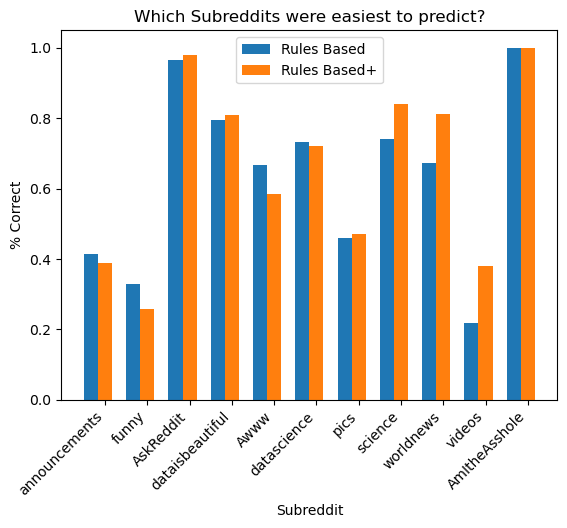

In [373]:
obj.compare(['Rules Based', 'Rules Based+'])

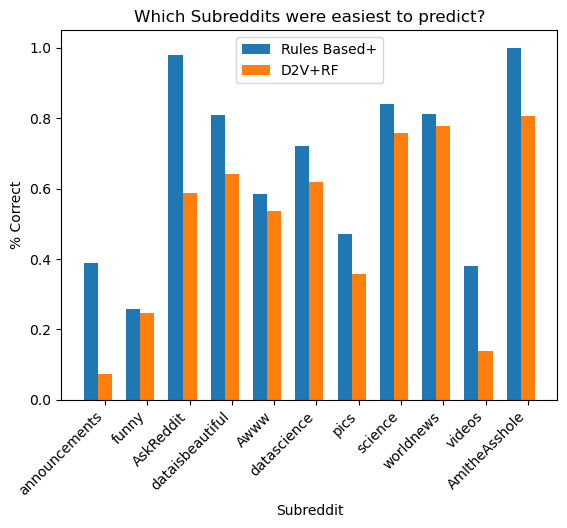

In [374]:
obj.compare(['Rules Based+', 'D2V+RF'])

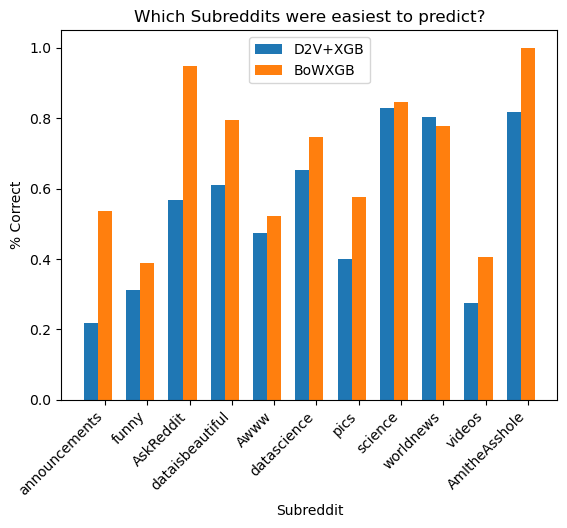

In [388]:
obj.compare(['D2V+XGB', 'BoWXGB'])

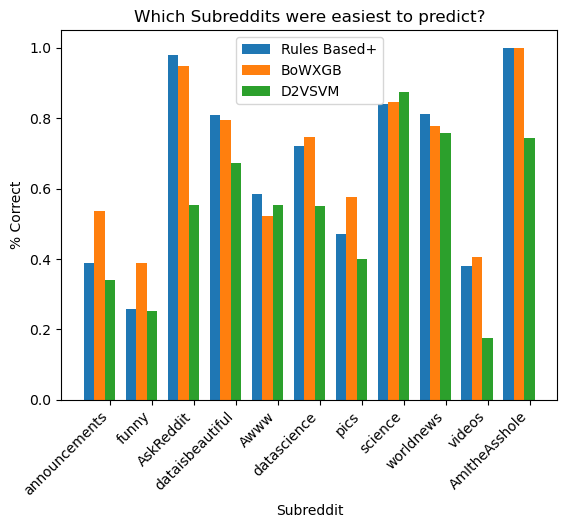

In [389]:
obj.compare([ 'Rules Based+', 'BoWXGB', 'D2VSVM' ])

## Discussion

Surprizingly, Bag-of-Words embeddings were far superior to more the sophisticated Doc2Vec embeddings. This is most likely due to the following reasons:
- BoW had ~14,000 features while D2V had 100
- D2V is much more effective with a larger corpus

XGBoost preformed comparable to Random Forrest, with a slight advantage over Random Forrest for more difficult categories such as r/announcements and r/funny.

The presence of the addtional information about the length of a post helped mostly in r/worldnews, r/science, and r/videos. This was to be expected after viewing the graphs from the Analyzing the Data phase.

## Proposal

Create 3 new embeddings, each with exactly 1000 features. 1 with 1000 most important BoW features, 1 with 1000 D2V, and 1 with 500 of each. Use this on XGBoost and see which preforms best.

In addition, I should create some auxillary embedding information to help with the poorer preforming subreddits. The inclusion of emojis will certainly help. As will question marks and a few other punctuation.

Idea Auxillary information:
- title length
- contains the word 'reddit' as a substring
- number of emojis
- number of each punctuation
- number of capital letters?
- sentiment?
- number of words from each part of speech
- topic?

In [404]:
df_raw[df_raw['subreddit'] == 'funny']

,id,title,subreddit
166,10gg34f,My watch is going insane [OC],funny
167,10gg044,This restaurant has had it with the missing gl...,funny
168,10gft2i,let’s see if anyone gets this,funny
169,10gfs2x,He’s a hero,funny
170,10gfp1i,Today’s fortune cookie says,funny
...,...,...,...
1017,10anc80,the cream in my coffee,funny
1018,10anbf3,Why has thou forsaken me,funny
1019,10amv44,Australian cricketer Scott Boland falling prey...,funny
1020,10amttk,Why would you eat the wrapper?,funny


In [405]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Create a list of sentences
sentences = ["This is a positive sentence.", "This is a negative sentence.", "This sentence is neutral."]

# Iterate over the sentences and get the sentiment scores
for sentence in sentences:
    sentiment = sia.polarity_scores(sentence)
    print(sentence)
    print(sentiment)


This is a positive sentence.
{'neg': 0.0, 'neu': 0.29, 'pos': 0.71, 'compound': 0.5994}
This is a negative sentence.
{'neg': 0.529, 'neu': 0.286, 'pos': 0.186, 'compound': -0.5267}
This sentence is neutral.
{'neg': 0.0, 'neu': 0.698, 'pos': 0.302, 'compound': 0.0772}


In [ ]:
dic = {'a':1, 'b':2, 'c':3}
dic = {key:dic[key] for key in ['a','b']}
dic

In [420]:
import nltk
import pandas as pd
from nltk import pos_tag
from nltk.tokenize import word_tokenize

def count_pos(sentences):
    # Create a dictionary to store the POS counts
    pos_counts = {'CC': 0, 'CD': 0, 'DT': 0, 'EX': 0, 'FW': 0, 'IN': 0, 'JJ': 0, 'JJR': 0, 'JJS': 0, 'LS': 0, 'MD': 0, 'NN': 0, 'NNS': 0, 'NNP': 0, 'NNPS': 0, 'PDT': 0, 'POS': 0, 'PRP': 0, 'PRP$': 0, 'RB': 0, 'RBR': 0, 'RBS': 0, 'RP': 0, 'SYM': 0, 'TO': 0, 'UH': 0, 'VB': 0, 'VBD': 0, 'VBG': 0, 'VBN': 0, 'VBP': 0, 'VBZ': 0, 'WDT': 0, 'WP': 0, 'WP$': 0, 'WRB': 0}

    # Iterate over the sentences
    for sentence in sentences:
        # Tokenize and POS tag the sentence
        tagged_tokens = pos_tag(word_tokenize(sentence))

        # Iterate over the tagged tokens
        for token in tagged_tokens:
            # If the POS is in the dictionary, increment the count
            if token[1] in pos_counts:
                pos_counts[token[1]] += 1

    # Create a DataFrame from the POS counts dictionary
    pos_df = pd.DataFrame(pos_counts, index=[0])

    return pos_df


In [422]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\raino\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [424]:
import pandas as pd

# Create a sample pandas Series
sentences = pd.Series(["This is a positive sentence.", "This is a negative sentence.", "This sentence is neutral."])

# Pass the Series to the count_pos function
pos_df = count_pos(sentences)

pos_df


,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,0,0,5,0,0,0,3,0,0,0,...,0,0,0,0,0,3,0,0,0,0


In [ ]:


temp_X_train = obj.Feature_Vectors['D2V+'].loc[obj._train_index]
temp_Y_train = obj.Y_train

temp_model = _XGBoost_train(temp_X_train, temp_Y_train)
#temp_predictions = _SVM_predict(temp_X_test, temp_model)
#temp_predictions

In [ ]:
temp_title_vectors = obj.Feature_Vectors['D2V+'].loc[obj._test_index]

temp_predictions = _XGBoost_predict(temp_title_vectors, temp_model)
temp_predictions

In [ ]:
obj.Feature_Vectors['D2V']

In [ ]:
obj.full_data

In [ ]:

"""
def more_than_120(sentence):
    return (len(sentence)>120)

def less_than_25(sentence):
    return (len(sentence)<25)


def has_chinese_characters(sentence):
    # Use regular expression to match any Chinese characters
    chinese_characters_pattern = re.compile(r"[\u4e00-\u9fa5]+")
    if chinese_characters_pattern.search(sentence):
        return True
    else:
        return False

def has_special_characters(sentence):
    # Use regular expression to match any characters that are not latin alpha numeric, punctuation, emojis, or special symbols
    special_characters_pattern = re.compile(r"[^\w\s~!@#$%^&*()_\u263a-\U0001f645\u2600-\u26ff\u2700-\u27bf]+")
    if special_characters_pattern.search(sentence):
        return True
    else:
        return False
"""

#conditions['is long'] = more_than_120
#conditions['has chinese'] = has_chinese_characters
#conditions['is short'] = less_than_25
#conditions['has special characters'] = has_special_characters

In [ ]:

def has_special_characters(sentence):
    std_american_keyboard_chars = r"\"!#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~"
    special_characters_pattern = re.compile(f"[^{std_american_keyboard_chars}\u263a-\U0001f645\u2600-\u26ff\u2700-\u27bf]+")
    if special_characters_pattern.search(sentence):
        return True
    else:
        return False


df[df['title'].apply(has_special_characters)]



In [ ]:
# test sentences
sentences = [
    "I love 🍕 pizza! 🍕",  # False
    "I love pizza! 🍕", # False
    "I love pizza! 🍕🍕🍕", # False
    "I love 🍕 pizza! 🍕🍕🍕", # False
    "I løve אַַ pizza! 🍕", # True
    "I løve אַַ🍕 pizza! 🍕🍕🍕", # True
    "I løve 🍕 pi🍕za! אַַ🍕🍕🍕", # True
    "I løve 🍕 pi🍕za! אַַ🍕🍕🍕🍕", # True
    "I løve 🍕 pi🍕za! אַַ🍕🍕🍕🍕🍕", # True
    "I løve 🍕 pi🍕za! אַַ🍕🍕🍕🍕🍕🍕", #True
]

# test the function on each sentence
for sentence in sentences:
    print(f"{sentence}: {has_special_characters(sentence)}")


In [ ]:
sentence = "I love pizza, 🍕"
print(has_special_characters(sentence)) # False


In [ ]:
table = pd.DataFrame(columns=['Condition', '% Correct', 'Total Affected'])


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Initialize an empty dictionary to store the data
data = {}

# Iterate over the top_subreddits
for subreddit in top_subreddits:
    # Get the titles for the subreddit
    titles = df_raw[df_raw['subreddit'] == subreddit]['title']
    # Get the number of non-alpha-numeric characters in the titles
    num_nonalphanumeric = [len(re.findall('[^A-Za-z0-9]+', title)) for title in titles]
    # Get the percentage of titles for the subreddit with a specific number of non-alpha-numeric characters
    percentages = []
    for i in range(max(num_nonalphanumeric)):
        percentages.append(num_nonalphanumeric.count(i)/len(num_nonalphanumeric))
    # Add the data to the dictionary
    data[subreddit] = percentages

# Plot the data
for subreddit, percentages in data.items():
    plt.plot(range(len(percentages)), percentages, label=subreddit)

# Add labels and title
plt.xlabel("Number of non-alpha-numeric characters")
plt.ylabel("Percentage of titles")
plt.title("Percentage of titles by number of non-alpha-numeric characters and subreddit")
plt.legend()

# Show
plt.show()


In [ ]:
pip install emoji

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import emoji

# Initialize an empty dictionary to store the data
data = {}

# Iterate over the top_subreddits
for subreddit in top_subreddits:
    # Get the titles for the subreddit
    titles = df_raw[df_raw['subreddit'] == subreddit]['title']
    # Get the number of emojis in the titles
    num_emojis = [len(emoji.emojize(title)) for title in titles]
    # Get the percentage of titles for the subreddit with a specific number of emojis
    percentages = []
    for i in range(max(num_emojis)):
        percentages.append(num_emojis.count(i)/len(num_emojis))
    # Add the data to the dictionary
    data[subreddit] = percentages

# Plot the data
for subreddit, percentages in data.items():
    plt.plot(range(len(percentages)), percentages, label=subreddit)

# Add labels and title
plt.xlabel("Number of emojis")
plt.ylabel("Percentage of titles")
plt.title("Percentage of titles by number of emojis and subreddit")
plt.legend()

# Show
plt.show()

In [ ]:
import re

def has_emoji(sentence):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64f"  # emoticons
                               u"\U0001F300-\U0001F5ff"  # symbols & pictographs
                               u"\U0001F680-\U0001F6ff"  # transport & map symbols
                               u"\U0001F1e0-\U0001F1ff"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.search(sentence) is not None


In [ ]:
sentence = "I love pizza 🍕"
print(has_emoji(sentence)) # True


In [ ]:
list(map(has_emoji, ["hello world :D ! ","I love pizza 🍕", "!@#$%^&*()_+1234567890-=" ]))

In [431]:
import re

def filter_emoji(df):
    # Create a regular expression pattern to match emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    # Use the 'apply' method to apply the regular expression search to the 'title' column
    df['emoji_in_title'] = df['title'].apply(lambda x: bool(emoji_pattern.search(x)))
    df = df[df.emoji_in_title == True]
    return df


filter_emoji(df_raw)

,title,subreddit,emoji_in_title
id,,,
10fwpud,Dude that looks like Patrick Beverly playing h...,funny,True
10ftbli,My schools cooking class has two groups. You c...,funny,True
10fresi,Forgot the old man was fishin and about had a ...,funny,True
10fepbx,I put a spell on you…cause you’re mine 🎶,funny,True
10ez0le,Who else has THAT friend? Can’t go no where wi...,funny,True
...,...,...,...
10ez54e,Using ai to write viral TikToks 😂,videos,True
10evz2c,Harry Pinero is so smooth👏🏼😭,videos,True
10evbk4,Trees of beautiful British Columbia 🌲,videos,True


In [439]:
df_raw

,title,subreddit,emoji_in_title
id,,,
t93ec3,This subreddit is closed for new posts and com...,announcements,False
pg006s,COVID denialism and policy clarifications,announcements,False
pbmy5y,"Debate, dissent, and protest on Reddit",announcements,False
nw2hs6,Sunsetting Secret Santa and Reddit Gifts,announcements,False
mi01fg,Second,announcements,False
...,...,...,...
10ds6b2,WIBTA if I lied to my husband about not keepin...,AmItheAsshole,False
10ds0k3,AITA for refusing to work?,AmItheAsshole,False
10drxdx,"AITA for ""not wanting"" to sit next to my best ...",AmItheAsshole,False


In [6]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a list of documents as input for the CountVectorizer
documents = ["this, is a test", "this is 🍕 pizza piZZa another 'test'", "This is yet another test!"]

# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the vectorizer on the documents
X = vectorizer.fit_transform(documents)

# Get the feature names
features = vectorizer.get_feature_names()
print("Feature names:", features)

# Get the feature vectors
vectors = X.toarray()
print("Feature vectors:", vectors)


Feature names: ['another', 'is', 'pizza', 'test', 'this', 'yet']
Feature vectors: [[0 1 0 1 1 0]
 [1 1 2 1 1 0]
 [1 1 0 1 1 1]]


C:\Users\raino\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [8]:
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import CountVectorizer

# Create a list of documents as input for the CountVectorizer
documents = ["this, is a test", "this is 🍕 pizza piZZa another 'test'", "This is yet another test!"]

# Use Gensim to tag the documents
tagged_documents = [simple_preprocess(doc) for doc in documents]

# Initialize the CountVectorizer
vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)

# Fit and transform the vectorizer on the tagged documents
X = vectorizer.fit_transform(tagged_documents)

# Get the feature names
features = vectorizer.get_feature_names()
print("Feature names:", features)

# Get the feature vectors
vectors = X.toarray()
print("Feature vectors:", vectors)


Feature names: ['another', 'is', 'pizza', 'test', 'this', 'yet']
Feature vectors: [[0 1 0 1 1 0]
 [1 1 2 1 1 0]
 [1 1 0 1 1 1]]


In [9]:
tagged_documents

[['this', 'is', 'test'],
 ['this', 'is', 'pizza', 'pizza', 'another', 'test'],
 ['this', 'is', 'yet', 'another', 'test']]

In [20]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer

# Create a list of documents as input for the CountVectorizer
documents = ["[oc] this, is a test", "(oc) this is 🍕 __emoji__ pizza piZZa another: 'test'", 'This is yet another "test"!']

# Use NLTK to tag the documents
tagged_documents = [nltk.pos_tag(nltk.word_tokenize(doc)) for doc in documents]

# Initialize the CountVectorizer
vectorizer = CountVectorizer(tokenizer=lambda doc: [(word,  tag) for word, tag in doc], lowercase=False)

# Fit and transform the vectorizer on the tagged documents
X = vectorizer.fit_transform(tagged_documents)

# Get the feature names
features = vectorizer.get_feature_names()
print("Feature names:", features)

# Get the feature vectors
vectors = X.toarray()
print("Feature vectors:", vectors)


Feature names: [('!', '.'), ("'", "''"), ("''", "''"), ("'test", 'JJS'), ('(', '('), (')', ')'), (',', ','), (':', ':'), ('This', 'DT'), ('[', 'JJ'), (']', 'NN'), ('__emoji__', 'NNP'), ('``', '``'), ('a', 'DT'), ('another', 'DT'), ('is', 'VBZ'), ('oc', 'NN'), ('piZZa', 'NN'), ('pizza', 'NN'), ('test', 'NN'), ('this', 'DT'), ('yet', 'RB'), ('🍕', 'JJ')]
Feature vectors: [[0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 0 0]
 [0 1 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1]
 [1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0]]


In [16]:
tagged_documents

[[('[', 'JJ'),
  ('oc', 'NN'),
  (']', 'NN'),
  ('this', 'DT'),
  (',', ','),
  ('is', 'VBZ'),
  ('a', 'DT'),
  ('test', 'NN')],
 [('(', '('),
  ('oc', 'NN'),
  (')', ')'),
  ('this', 'DT'),
  ('is', 'VBZ'),
  ('🍕', 'JJ'),
  ('pizza', 'NN'),
  ('piZZa', 'NN'),
  ('another', 'DT'),
  ("'test", 'JJS'),
  ("'", "''")],
 [('This', 'DT'),
  ('is', 'VBZ'),
  ('yet', 'RB'),
  ('another', 'DT'),
  ('``', '``'),
  ('test', 'NN'),
  ("''", "''"),
  ('!', '.')]]

In [26]:
df_raw

,title,subreddit
id,,
t93ec3,This subreddit is closed for new posts and com...,announcements
pg006s,COVID denialism and policy clarifications,announcements
pbmy5y,"Debate, dissent, and protest on Reddit",announcements
nw2hs6,Sunsetting Secret Santa and Reddit Gifts,announcements
mi01fg,Second,announcements
...,...,...
10f99lt,AITA for exposing what was told to me in confi...,AmItheAsshole
10f942p,AITA for getting cosmetic surgery while my sis...,AmItheAsshole
10f8zxj,AITA for refusing to take my wife to work,AmItheAsshole


In [40]:
# Create an empty list to store the posts
posts_new = []

# Iterate through the subreddits and get the last 1000 posts from each
for sub in ['all']:
    subreddit_posts = reddit.subreddit(sub).hot(limit=10000)
    for post in subreddit_posts:
        posts_new.append(post)

# Create a list of dictionaries containing the data for each post
data_new = [{'id': post.id, 'title': post.title, 'subreddit': post.subreddit.display_name} for post in posts_new]

# Create a Pandas dataframe from the list of dictionaries
df_raw_new = pd.DataFrame(data_new)
df_raw_new = df_raw_new.set_index('id')
df_raw_new

,title,subreddit
id,,
10hxsh0,[OC] Sarge?!,comics
10hvpgm,My stealth bomber,aww
10hvjxw,Overly excited pomeranian does agility,nextfuckinglevel
10hwvv6,Group of Tulsa high schoolers ditched class to...,pics
10hv8d8,Some French comedians made a video about it's ...,funny
...,...,...
10hydyr,Eggs baby,memes
10i0aw0,Divide and conquer,memes
10hxv8z,once i get friends,memes


In [31]:
len(data_new)

846

In [35]:
df_raw_new = pd.DataFrame(data_new)
df_raw_new = df_raw_new.set_index('id')
df_raw_new

,title,subreddit
id,,
10i26p0,Laundry Machine laying sick beats for Mos Def ...,funny
10i24jp,Jeff Bezos life story (parody),funny
10i24d0,These optional upcharges at the bar’s discretion,funny
10i1u7z,How my 4-year-old ate her pizza for lunch today.,funny
10i1poo,What’s the deal with Alpha and Beta Males? Scr...,funny
...,...,...
10cchfa,"""I just followed the designs""",funny
10cbgnh,Found this in some old pics of my parents wedding,funny
10cbd6u,What am I supposed to be doing?,funny
